In [1]:
# Importing the required libraries

In [ ]:
# importing the required libraries
import pandas as pd

# Visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium 
from folium import plugins

# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 10, 12

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [300]:
# Part 1: Analysing the present condition in India

In [301]:
# 1.1 Scraping the datasets from the official Govt. website

In [302]:
# for date and time opeations
from datetime import datetime
# for file and folder operations
import os
# for regular expression opeations
import re
# for listing files in a folder
import glob
# for getting web contents
import requests 
# for scraping web contents
from bs4 import BeautifulSoup

In [303]:
# get data

# link at which web data recides
link = 'https://www.mohfw.gov.in/'
# get web data
req = requests.get(link)
# parse web data
soup = BeautifulSoup(req.content, "html.parser")

In [304]:
# find the table
# ==============
# our target table is the last table in the page

# get the table head
# table head may contain the column names, titles, subtitles
thead = soup.find_all('thead')[-1]
# print(thead)

# get all the rows in table head
# it usually have only one row, which has the column names
head = thead.find_all('tr')
# print(head)

# get the table tbody
# it contains the contents
tbody = soup.find_all('tbody')[-1]
# print(tbody)

# get all the rows in table body
# each row is each state's entry
body = tbody.find_all('tr')
# print(body)

In [305]:
# get the table contents
# ======================

# container for header rows / column title
head_rows = []
# container for table body / contents
body_rows = []

# loop through the head and append each row to head
for tr in head:
    td = tr.find_all(['th', 'td'])
    row = [i.text for i in td]
    head_rows.append(row)
# print(head_rows)

# loop through the body and append each row to body
for tr in body:
    td = tr.find_all(['th', 'td'])
    row = [i.text for i in td]
    body_rows.append(row)
# print(head_rows)

In [306]:
# save contents in a dataframe
# ============================
    
# skip last 3 rows, it contains unwanted info
# head_rows contains column title
df_bs = pd.DataFrame(body_rows[:len(body_rows)-6], 
                     columns=head_rows[0])         

# Drop 'S. No.' column
df_bs.drop('S. No.', axis=1, inplace=True)

# there are 36 states+UT in India
df_bs.head(36)

,Name of State / UT,Active Cases*,Cured/Discharged/Migrated*,Deaths**,Total Confirmed cases*
0,Andaman and Nicobar Islands,72,77,0,149
1,Andhra Pradesh,10894,11101,264,22259
2,Arunachal Pradesh,176,109,2,287
3,Assam,4591,8729,16,13336
4,Bihar,3528,9554,107,13189
5,Chandigarh,104,402,7,513
6,Chhattisgarh,676,2835,14,3525
7,Dadra and Nagar Haveli and Daman and Diu,224,184,0,408
8,Delhi,23452,78199,3213,104864
9,Goa,824,1207,8,2039


In [307]:
# Data Cleaning

In [308]:
# date-time information
# =====================
#saving a copy of the dataframe
df_India = df_bs.copy()
# today's date
now  = datetime.now()
# format date to month-day-year
df_India['Date'] = now.strftime("%m/%d/%Y") 

# add 'Date' column to dataframe
df_India['Date'] = pd.to_datetime(df_India['Date'], format='%m/%d/%Y')


In [309]:
# remove extra characters from 'Name of State/UT' column
df_India['Name of State / UT'] = df_India['Name of State / UT'].str.replace('#', '')
df_India['Deaths**'] = df_India['Deaths**'].str.replace('#', '')

In [310]:
# latitude and longitude information
# ==================================

# latitude of the states
lat = {'Delhi':28.7041, 'Haryana':29.0588, 'Kerala':10.8505, 'Rajasthan':27.0238,
       'Telangana':18.1124, 'Uttar Pradesh':26.8467, 'Ladakh':34.2996, 'Tamil Nadu':11.1271,
       'Jammu and Kashmir':33.7782, 'Punjab':31.1471, 'Karnataka':15.3173, 'Maharashtra':19.7515,
       'Andhra Pradesh':15.9129, 'Odisha':20.9517, 'Uttarakhand':30.0668, 'West Bengal':22.9868, 
       'Puducherry': 11.9416, 'Chandigarh': 30.7333, 'Chhattisgarh':21.2787, 'Gujarat': 22.2587, 
       'Himachal Pradesh': 31.1048, 'Madhya Pradesh': 22.9734, 'Bihar': 25.0961, 'Manipur':24.6637, 
       'Mizoram':23.1645, 'Goa': 15.2993, 'Andaman and Nicobar Islands': 11.7401, 'Assam' : 26.2006, 
       'Jharkhand': 23.6102, 'Arunachal Pradesh': 28.2180, 'Tripura': 23.9408, 'Nagaland': 26.1584, 
       'Meghalaya' : 25.4670, 'Dadra and Nagar Haveli and Daman and Diu' : 20.1809, 'Sikkim': 27.5330}

# longitude of the states
long = {'Delhi':77.1025, 'Haryana':76.0856, 'Kerala':76.2711, 'Rajasthan':74.2179,
        'Telangana':79.0193, 'Uttar Pradesh':80.9462, 'Ladakh':78.2932, 'Tamil Nadu':78.6569,
        'Jammu and Kashmir':76.5762, 'Punjab':75.3412, 'Karnataka':75.7139, 'Maharashtra':75.7139,
        'Andhra Pradesh':79.7400, 'Odisha':85.0985, 'Uttarakhand':79.0193, 'West Bengal':87.8550, 
        'Puducherry': 79.8083, 'Chandigarh': 76.7794, 'Chhattisgarh':81.8661, 'Gujarat': 71.1924, 
        'Himachal Pradesh': 77.1734, 'Madhya Pradesh': 78.6569, 'Bihar': 85.3131, 'Manipur':93.9063, 
        'Mizoram':92.9376, 'Goa': 74.1240, 'Andaman and Nicobar Islands': 92.6586, 'Assam' : 92.9376, 
        'Jharkhand': 85.2799, 'Arunachal Pradesh': 94.7278, 'Tripura': 91.9882, 'Nagaland': 94.5624,
        'Meghalaya' : 91.3662, 'Dadra and Nagar Haveli and Daman and Diu' : 73.0169, 'Sikkim': 88.5122}

# add latitude column based on 'Name of State / UT' column
df_India['Latitude'] = df_India['Name of State / UT'].map(lat)

# add longitude column based on 'Name of State / UT' column
df_India['Longitude'] = df_India['Name of State / UT'].map(long)

df_India.head(36)

,Name of State / UT,Active Cases*,Cured/Discharged/Migrated*,Deaths**,Total Confirmed cases*,Date,Latitude,Longitude
0,Andaman and Nicobar Islands,72,77,0,149,2020-07-10,11.7401,92.6586
1,Andhra Pradesh,10894,11101,264,22259,2020-07-10,15.9129,79.7400
2,Arunachal Pradesh,176,109,2,287,2020-07-10,28.2180,94.7278
3,Assam,4591,8729,16,13336,2020-07-10,26.2006,92.9376
4,Bihar,3528,9554,107,13189,2020-07-10,25.0961,85.3131
5,Chandigarh,104,402,7,513,2020-07-10,30.7333,76.7794
6,Chhattisgarh,676,2835,14,3525,2020-07-10,21.2787,81.8661
7,Dadra and Nagar Haveli and Daman and Diu,224,184,0,408,2020-07-10,20.1809,73.0169
8,Delhi,23452,78199,3213,104864,2020-07-10,28.7041,77.1025
9,Goa,824,1207,8,2039,2020-07-10,15.2993,74.1240


In [311]:
# rename columns
    
df_India = df_India.rename(columns={'Cured/Discharged/Migrated' :'Cured/Discharged', 
                                      'Total Confirmed cases *': 'Confirmed', 
                                      'Total Confirmed cases ': 'Confirmed', 
                                      'Total Confirmed cases* ': 'Confirmed'})
df_India = df_India.rename(columns={'Cured/Discharged':'Cured'})
df_India = df_India.rename(columns={'Name of State / UT':'State/UnionTerritory'})
df_India = df_India.rename(columns={'Name of State / UT':'State/UnionTerritory'})

df_India = df_India.rename(columns=lambda x: re.sub('Total Confirmed cases \(Including .* foreign Nationals\) ',
                                                      'Total Confirmed cases',x))
df_India = df_India.rename(columns={'Deaths ( more than 70% cases due to comorbidities )':'Deaths', 
                                      'Deaths**':'Deaths'})

In [312]:
# unique state names
df_India['State/UnionTerritory'].unique()

array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
       'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
       'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu',
       'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
       'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
       'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
       'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan',
       'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttarakhand',
       'Uttar Pradesh', 'West Bengal'], dtype=object)

In [313]:
# number of missing values 
df_India.isna().sum()

State/UnionTerritory          0
Active Cases*                 0
Cured/Discharged/Migrated*    0
Deaths                        0
Total Confirmed cases*        0
Date                          0
Latitude                      0
Longitude                     0
dtype: int64

In [314]:
# number of unique values 
df_India.nunique()

State/UnionTerritory          35
Active Cases*                 35
Cured/Discharged/Migrated*    35
Deaths                        27
Total Confirmed cases*        35
Date                           1
Latitude                      35
Longitude                     31
dtype: int64

In [315]:
# Saving data

In [316]:
# saving data
# ===========

# file names as year-month-day.csv format
file_name = now.strftime("%Y_%m_%d")+' - COVID-19_India.csv'

# location for saving the file
file_loc = r'C:\Users\Srishiti\Desktop\projects\covid analysis'

# save file as a scv file
df_India.to_csv(file_loc + file_name, index=False)

# df_India.head(36)

In [317]:
# fix datatype
df_India['Date'] = pd.to_datetime(df_India['Date'])

In [318]:
# rename state/UT names
df_India['State/UnionTerritory'].replace('Chattisgarh', 'Chhattisgarh', inplace=True)
df_India['State/UnionTerritory'].replace('Pondicherry', 'Puducherry', inplace=True) 

In [319]:
# Final dataframe

In [320]:
df_India.head(36)

,State/UnionTerritory,Active Cases*,Cured/Discharged/Migrated*,Deaths,Total Confirmed cases*,Date,Latitude,Longitude
0,Andaman and Nicobar Islands,72,77,0,149,2020-07-10,11.7401,92.6586
1,Andhra Pradesh,10894,11101,264,22259,2020-07-10,15.9129,79.7400
2,Arunachal Pradesh,176,109,2,287,2020-07-10,28.2180,94.7278
3,Assam,4591,8729,16,13336,2020-07-10,26.2006,92.9376
4,Bihar,3528,9554,107,13189,2020-07-10,25.0961,85.3131
5,Chandigarh,104,402,7,513,2020-07-10,30.7333,76.7794
6,Chhattisgarh,676,2835,14,3525,2020-07-10,21.2787,81.8661
7,Dadra and Nagar Haveli and Daman and Diu,224,184,0,408,2020-07-10,20.1809,73.0169
8,Delhi,23452,78199,3213,104864,2020-07-10,28.7041,77.1025
9,Goa,824,1207,8,2039,2020-07-10,15.2993,74.1240


In [321]:
# complete data info
df_India.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 8 columns):
State/UnionTerritory          35 non-null object
Active Cases*                 35 non-null object
Cured/Discharged/Migrated*    35 non-null object
Deaths                        35 non-null object
Total Confirmed cases*        35 non-null object
Date                          35 non-null datetime64[ns]
Latitude                      35 non-null float64
Longitude                     35 non-null float64
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 2.3+ KB


In [322]:
# Save as .csv file

In [323]:
# saving data
# ===========

# file names as year-month-day.csv format
file_name = now.strftime("%Y_%m_%d")+' - COVID-19_India_preprocessed.csv'

# location for saving the file
file_loc = r'C:\Users\Srishiti\Desktop\projects\covid analysis'


In [324]:
#Learn how to read a .csv file by creating a dataframe using pandas
# Reading the datasets
df= pd.read_csv(r'C:\Users\Srishiti\Desktop\projects\covid analysis2020_07_09 - COVID-19_India.csv')
df_india = df.copy()
df

,State/UnionTerritory,Active Cases*,Cured/Discharged/Migrated*,Deaths,Total Confirmed cases*,Date,Latitude,Longitude
0,Andaman and Nicobar Islands,72,77,0,149,2020-07-09,11.7401,92.6586
1,Andhra Pradesh,10894,11101,264,22259,2020-07-09,15.9129,79.7400
2,Arunachal Pradesh,176,109,2,287,2020-07-09,28.2180,94.7278
3,Assam,4591,8729,16,13336,2020-07-09,26.2006,92.9376
4,Bihar,3528,9554,107,13189,2020-07-09,25.0961,85.3131
5,Chandigarh,104,402,7,513,2020-07-09,30.7333,76.7794
6,Chhattisgarh,676,2835,14,3525,2020-07-09,21.2787,81.8661
7,Dadra and Nagar Haveli and Daman and Diu,224,184,0,408,2020-07-09,20.1809,73.0169
8,Delhi,23452,78199,3213,104864,2020-07-09,28.7041,77.1025
9,Goa,824,1207,8,2039,2020-07-09,15.2993,74.1240


In [325]:
# 1.2 Analysing COVID19 Cases in India

In [326]:
total_cases = df['Total Confirmed cases*'].sum()
print('Total number of confirmed COVID 2019 cases across India till date:', total_cases)

Total number of confirmed COVID 2019 cases across India till date: 762911


In [327]:
# highlighting dataframe
df_temp = df.drop(['Latitude', 'Longitude', 'Date'], axis = 1) #Removing Date, Latitude and Longitude and other extra columns
df_temp.style.background_gradient(cmap='Reds')

,State/UnionTerritory,Active Cases*,Cured/Discharged/Migrated*,Deaths,Total Confirmed cases*
0,Andaman and Nicobar Islands,72,77,0,149
1,Andhra Pradesh,10894,11101,264,22259
2,Arunachal Pradesh,176,109,2,287
3,Assam,4591,8729,16,13336
4,Bihar,3528,9554,107,13189
5,Chandigarh,104,402,7,513
6,Chhattisgarh,676,2835,14,3525
7,Dadra and Nagar Haveli and Daman and Diu,224,184,0,408
8,Delhi,23452,78199,3213,104864
9,Goa,824,1207,8,2039


In [328]:
today = now.strftime("%Y_%m_%d")
total_cured = df['Cured/Discharged/Migrated*'].sum()
print("Total people who were cured as of "+today+" are: ", total_cured)
total_cases = df['Total Confirmed cases*'].sum()
print("Total people who were detected COVID+ve as of "+today+" are: ", total_cases)
total_death = df['Deaths'].sum()
print("Total people who died due to COVID19 as of "+today+" are: ",total_death)
total_active = total_cases-total_cured-total_death
print("Total active COVID19 cases as of "+today+" are: ",total_active)

Total people who were cured as of 2020_07_10 are:  476378
Total people who were detected COVID+ve as of 2020_07_10 are:  762911
Total people who died due to COVID19 as of 2020_07_10 are:  21129
Total active COVID19 cases as of 2020_07_10 are:  265404


In [329]:
#Total Active  is the Total cases - (Number of death + Cured)
df['Total Active'] = df['Total Confirmed cases*'] - (df['Deaths'] + df['Cured/Discharged/Migrated*'])
total_active = df['Total Active'].sum()
print('Total number of active COVID 2019 cases across India:', total_active)
Tot_Cases = df.groupby('State/UnionTerritory')['Total Active'].sum().sort_values(ascending=False).to_frame()
Tot_Cases.style.background_gradient(cmap='Reds')

Total number of active COVID 2019 cases across India: 265404


,Total Active
State/UnionTerritory,
Maharashtra,91084
Tamil Nadu,46483
Delhi,23452
Karnataka,16531
Telangana,11933
Andhra Pradesh,10894
Uttar Pradesh,9980
Gujarat,9051
West Bengal,7705


In [330]:
import numpy as np
state_cases = df_india.groupby('State/UnionTerritory')['Total Confirmed cases*','Deaths','Cured/Discharged/Migrated*'].max().reset_index()

#state_cases = state_cases.astype({'Deaths': 'int'})
state_cases['Active'] = state_cases['Total Confirmed cases*'] - (state_cases['Deaths']+state_cases['Cured/Discharged/Migrated*'])
state_cases["Death Rate (per 100)"] = np.round(100*state_cases["Deaths"]/state_cases["Total Confirmed cases*"],2)
state_cases["Cure Rate (per 100)"] = np.round(100*state_cases["Cured/Discharged/Migrated*"]/state_cases["Total Confirmed cases*"],2)
state_cases.sort_values('Total Confirmed cases*', ascending= False).fillna(0).style.background_gradient(cmap='Blues',subset=["Total Confirmed cases*"])\
                        .background_gradient(cmap='Blues',subset=["Deaths"])\
                        .background_gradient(cmap='Blues',subset=["Cured/Discharged/Migrated*"])\
                        .background_gradient(cmap='Blues',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Blues',subset=["Cure Rate (per 100)"])

,State/UnionTerritory,Total Confirmed cases*,Deaths,Cured/Discharged/Migrated*,Active,Death Rate (per 100),Cure Rate (per 100)
19,Maharashtra,223724,9448,123192,91084,4.22,55.06
29,Tamil Nadu,122350,1700,74167,46483,1.39,60.62
8,Delhi,104864,3213,78199,23452,3.06,74.57
10,Gujarat,38333,1993,27289,9051,5.2,71.19
32,Uttar Pradesh,31156,845,20331,9980,2.71,65.26
30,Telangana,29536,324,17279,11933,1.1,58.5
15,Karnataka,28877,470,11876,16531,1.63,41.13
34,West Bengal,24823,827,16291,7705,3.33,65.63
1,Andhra Pradesh,22259,264,11101,10894,1.19,49.87
27,Rajasthan,22063,482,16866,4715,2.18,76.44


In [331]:
# Finding more detail COVID Insights in India

In [332]:
age_details = pd.read_csv(r'C:\Users\Srishiti\Desktop\projects\covid analysis\AgeGroupDetails_i0e5l.csv')
india_covid_19 = pd.read_csv(r'C:\Users\Srishiti\Desktop\projects\covid analysis\covid_19_india.csv')
hospital_beds = pd.read_csv(r'C:\Users\Srishiti\Desktop\projects\covid analysis\HospitalBedsIndia.csv')
individual_details = pd.read_csv(r'C:\Users\Srishiti\Desktop\projects\covid analysis\IndividualDetails.csv')
ICMR_details = pd.read_csv(r'C:\Users\Srishiti\Desktop\projects\covid analysis\ICMRTestingDetails.csv')
ICMR_labs = pd.read_csv(r'C:\Users\Srishiti\Desktop\projects\covid analysis\ICMRTestingLabs.csv')
state_testing = pd.read_csv(r'C:\Users\Srishiti\Desktop\projects\covid analysis\StatewiseTestingDetails.csv')
population = pd.read_csv(r'C:\Users\Srishiti\Desktop\projects\covid analysis\population_india_census2011.csv')

In [333]:
india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'],dayfirst = True)
state_testing['Date'] = pd.to_datetime(state_testing['Date'])
ICMR_details['DateTime'] = pd.to_datetime(ICMR_details['DateTime'],dayfirst = True)
ICMR_details = ICMR_details.dropna(subset=['TotalSamplesTested', 'TotalPositiveCases'])

In [334]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-04-2020.csv')

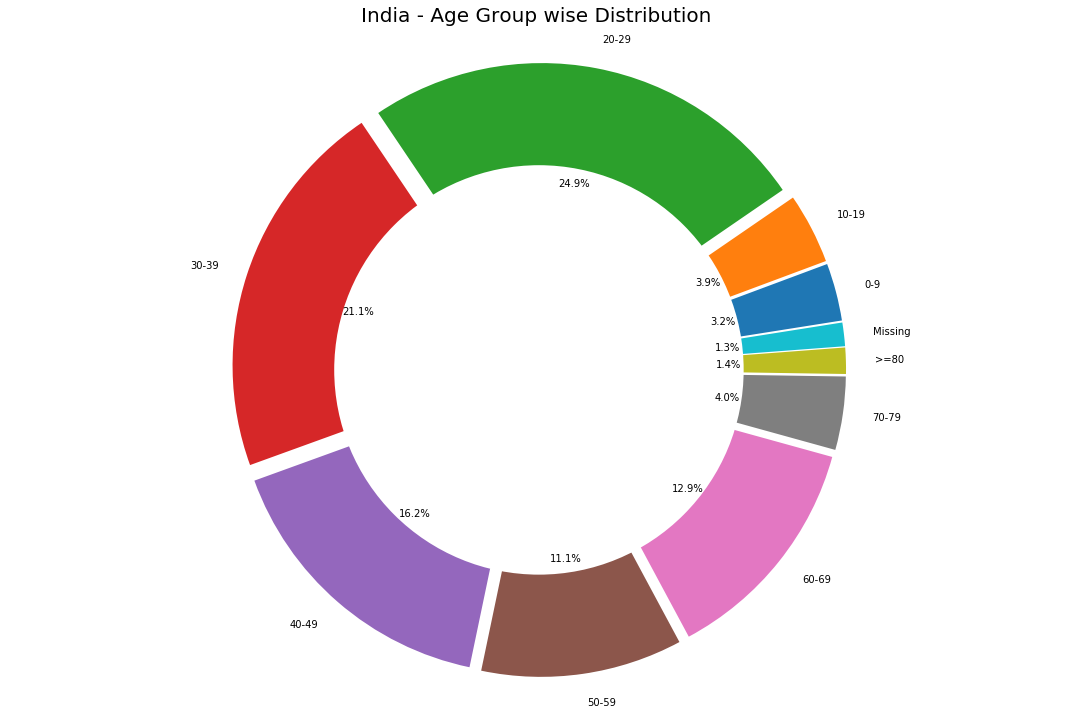

In [335]:
labels = list(age_details['AgeGroup'])
sizes = list(age_details['TotalCases'])

explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('India - Age Group wise Distribution',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

In [336]:
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

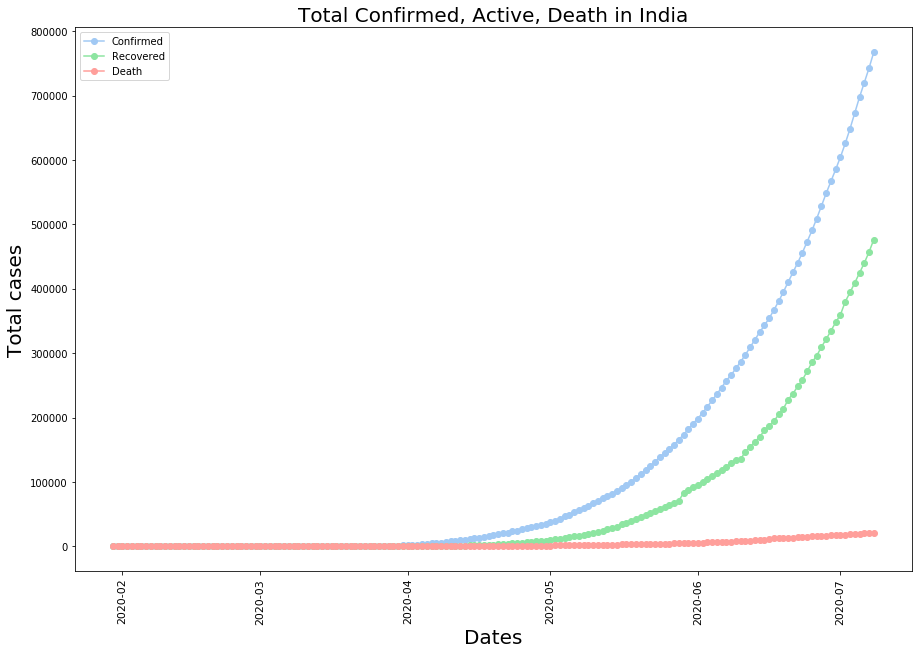

In [337]:
tes = list(pd.to_datetime(dates))
dates_india = dates[8:]
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

k = df1[df1['Country/Region']=='India'].loc[:,'1/30/20':]
india_confirmed = k.values.tolist()[0] 

k = df2[df2['Country/Region']=='India'].loc[:,'1/30/20':]
india_deaths = k.values.tolist()[0] 

k = df3[df3['Country/Region']=='India'].loc[:,'1/30/20':]
india_recovered = k.values.tolist()[0] 

plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Active, Death in India" , fontsize = 20)

ax1 = plt.plot_date(y= india_confirmed,x= dates_india,label = 'Confirmed',linestyle ='-',color = 'b')
ax2 = plt.plot_date(y= india_recovered,x= dates_india,label = 'Recovered',linestyle ='-',color = 'g')
ax3 = plt.plot_date(y= india_deaths,x= dates_india,label = 'Death',linestyle ='-',color = 'r')
plt.legend()

In [338]:
# Total Samples Tested

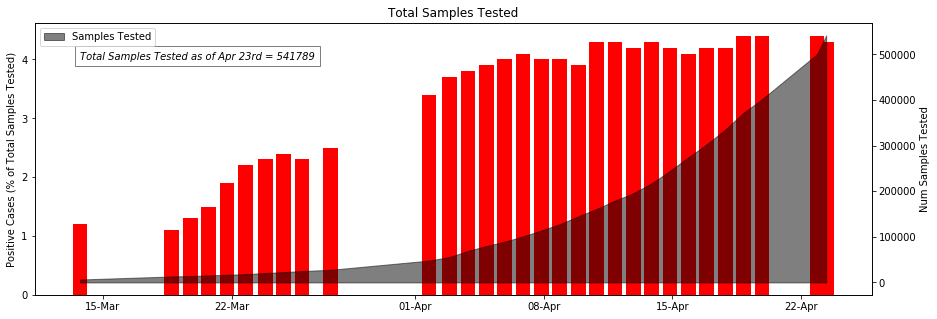

In [339]:
import matplotlib.dates as mdates
ICMR_details['Percent_positive'] = round((ICMR_details['TotalPositiveCases']/ICMR_details['TotalSamplesTested'])*100,1)

fig, ax1 = plt.subplots(figsize= (15,5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax1.set_ylabel('Positive Cases (% of Total Samples Tested)')
ax1.bar(ICMR_details['DateTime'] , ICMR_details['Percent_positive'], color="red",label = 'Percentage of Positive Cases')
ax1.text(ICMR_details['DateTime'][0],4, 'Total Samples Tested as of Apr 23rd = 541789', style='italic',fontsize= 10,
        bbox={'facecolor': 'white' ,'alpha': 0.5, 'pad': 5})

ax2 = ax1.twinx()  
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax2.set_ylabel('Num Samples Tested')
ax2.fill_between(ICMR_details['DateTime'],ICMR_details['TotalSamplesTested'],color = 'black',alpha = 0.5,label = 'Samples Tested');

plt.legend(loc="upper left")
plt.title('Total Samples Tested')
plt.show()


In [340]:
# Testing LIVE Status

In [341]:
import json
# get response from the web page
response = requests.get('https://api.covid19india.org/state_test_data.json')

# get contents from the response
content = response.content

# parse the json file
parsed = json.loads(content)

# keys
parsed.keys()

dict_keys(['states_tested_data'])

In [342]:
# save data in a dataframe
tested = pd.DataFrame(parsed['states_tested_data'])

# first few rows
tested.tail()

,coronaenquirycalls,cumulativepeopleinquarantine,negative,numcallsstatehelpline,numicubeds,numisolationbeds,numventilators,peopleinicu,peopleonventilators,populationncp2019projection,...,testsperpositivecase,testsperthousand,totaln95masks,totalpeoplecurrentlyinquarantine,totalpeoplereleasedfromquarantine,totalppe,totaltested,unconfirmed,updatedon,_d6ua4
2914,,,,,948,,395,,,96906000,...,24,5.58,1038040,5690,98563,1678262,541088,,05/07/2020,NaN
2915,,,,,948,,395,,,96906000,...,24,5.70,1047040,5605,99027,1688262,552007,,06/07/2020,NaN
2916,,,,,948,,395,,,,...,,,1057040,5294,99338,1698262,562137,,07/07/2020,NaN
2917,,,,,948,,395,,,,...,,,1067040,5152,99634,1708262,572523,,08/07/2020,NaN
2918,,,,,948,,395,,,,...,,,1079040,5090,100095,1718262,583328,,09/07/2020,NaN


In [343]:
# fix datatype
tested['updatedon'] = pd.to_datetime(tested['updatedon'])

In [344]:
# save file as a scv file
tested.to_csv('updated_tests_latest_state_level.csv', index=False)


In [345]:
state_test_cases = tested.groupby(['updatedon','state'])['totaltested','populationncp2019projection','testpositivityrate',	'testsperpositivecase',	'testsperthousand','totalpeoplecurrentlyinquarantine'].max().reset_index()

In [346]:
state_test_cases.head(36)

,updatedon,state,totaltested,populationncp2019projection,testpositivityrate,testsperpositivecase,testsperthousand,totalpeoplecurrentlyinquarantine
0,2020-01-04,Delhi,2621,19814000,0.00%,,0.13,
1,2020-01-04,Kerala,7965,35125000,3.33%,30,0.23,622
2,2020-01-04,West Bengal,659,96906000,5.61%,18,0.01,
3,2020-01-05,Andaman and Nicobar Islands,3754,397000,0.88%,114,9.46,643
4,2020-01-05,Andhra Pradesh,102460,52221000,1.43%,70,1.96,
5,2020-01-05,Arunachal Pradesh,724,1504000,0.28%,362,0.48,
6,2020-01-05,Assam,,34293000,,,0.00,
7,2020-01-05,Bihar,24118,119520000,1.93%,52,0.20,2156
8,2020-01-05,Chandigarh,1252,1179000,7.03%,14,1.06,
9,2020-01-05,Chhattisgarh,18039,28724000,0.24%,420,0.63,575


In [347]:
state_test_cases = tested.groupby('state')['totaltested','populationncp2019projection','testpositivityrate','testsperpositivecase',	'testsperthousand','totalpeoplecurrentlyinquarantine'].max()
state_test_cases['testpositivityrate'] = state_test_cases['testpositivityrate'].str.replace('%', '')

In [348]:
state_test_cases = state_test_cases.apply(pd.to_numeric)

In [349]:
state_test_cases.nunique()

totaltested                         35
populationncp2019projection         34
testpositivityrate                  34
testsperpositivecase                21
testsperthousand                    32
totalpeoplecurrentlyinquarantine    26
dtype: int64

In [350]:
state_test_cases.sort_values('totaltested', ascending= False).style.background_gradient(cmap='Blues',subset=["totaltested"])\
                        .background_gradient(cmap='Blues',subset=["populationncp2019projection"])\
                        .background_gradient(cmap='Blues',subset=["testpositivityrate"])\
                        .background_gradient(cmap='Blues',subset=["testsperpositivecase"])\
                        .background_gradient(cmap='Blues',subset=["testsperthousand"])\
                        .background_gradient(cmap='Blues',subset=["totalpeoplecurrentlyinquarantine"])
                       

,totaltested,populationncp2019projection,testpositivityrate,testsperpositivecase,testsperthousand,totalpeoplecurrentlyinquarantine
state,,,,,,
Andhra Pradesh,996573,52221000,7.33,94,9.77,nan
Maharashtra,995343,122153000,9.07,9,9.32,nan
Uttar Pradesh,988960,224979000,5.29,41,3.96,9911
Rajasthan,987272,77264000,2.88,49,9.97,nan
Haryana,99987,28672000,5.77,87,9.66,48749
Jharkhand,99931,37403000,1.79,99,4.26,99641
Kerala,99692,35125000,3.38,83,7.85,992
Madhya Pradesh,99677,82232000,9.77,27,5.08,nan
Bihar,99108,119520000,5.18,95,2.38,802


In [351]:
# Day-by-Day Confirmed Cases in Top 15 States in India

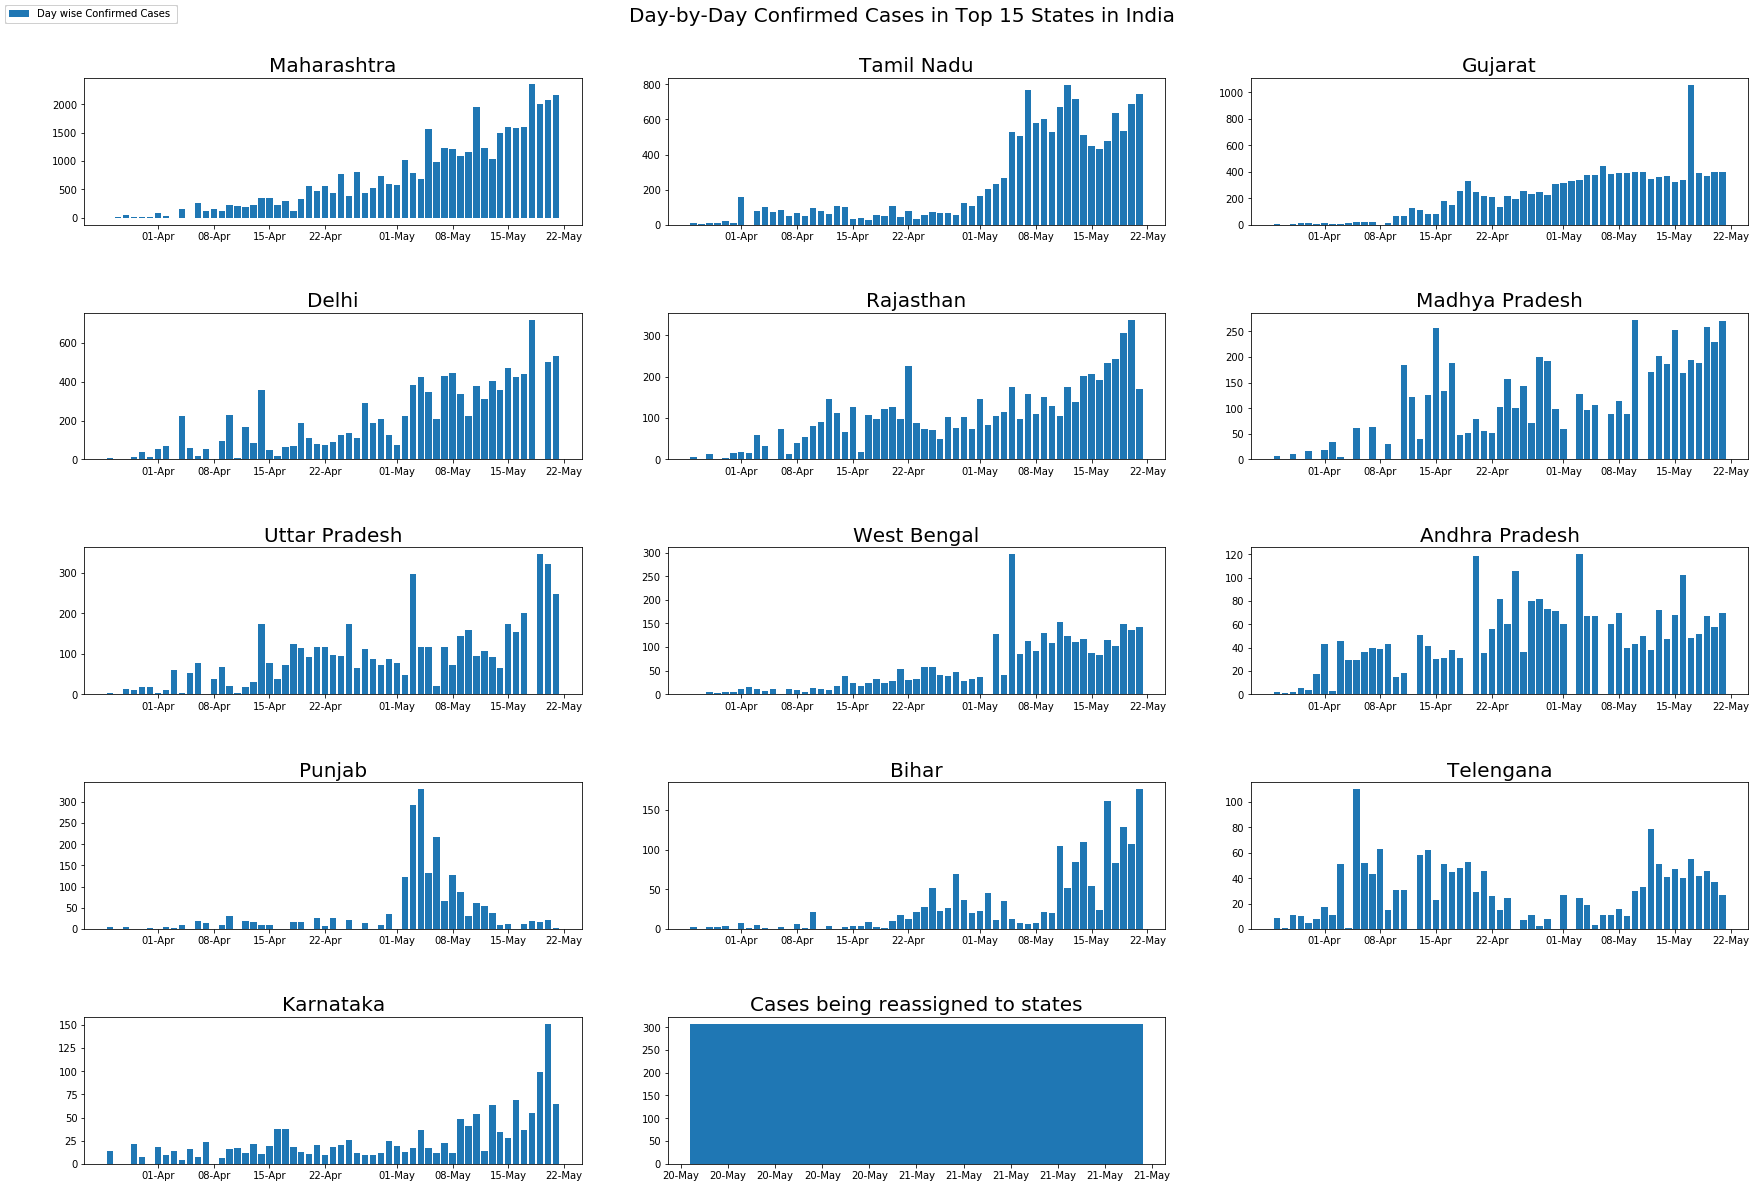

In [352]:
all_state = list(df_India['State/UnionTerritory'].unique())

latest = india_covid_19[india_covid_19['Date'] > '24-03-20']
state_cases = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
latest['Active Cases*'] = latest['Confirmed'] - (latest['Deaths']- latest['Cured'])
state_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0)
states =list(state_cases['State/UnionTerritory'][0:15])

states_confirmed = {}
states_deaths = {}
states_recovered = {}
states_dates = {}
states_active = {}

for state in states:
    df = latest[latest['State/UnionTerritory'] == state].reset_index()
    k = []
    l = []
    m = []
    n = []
    for i in range(1,len(df)):
        k.append(df['Confirmed'][i]-df['Confirmed'][i-1])
        l.append(df['Deaths'][i]-df['Deaths'][i-1])
        m.append(df['Cured'][i]-df['Cured'][i-1])
        n.append(df['Active Cases*'][i]-df['Active Cases*'][i-1])
    states_confirmed[state] = k
    states_deaths[state] = l
    states_recovered[state] = m
    states_active[state] = n
    date = list(df['Date'])
    states_dates[state] = date[1:]
    
fig = plt.figure(figsize= (25,17))
plt.suptitle('Day-by-Day Confirmed Cases in Top 15 States in India',fontsize = 20,y=1.0)
k=0
for i in range(1,15):
    ax = fig.add_subplot(5,3,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(states_dates[states[k]],states_confirmed[states[k]],label = 'Day wise Confirmed Cases ') 
    plt.title(states[k],fontsize = 20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1
plt.tight_layout(pad=5.0)

In [353]:
# Growth Rate in top 15 States in India

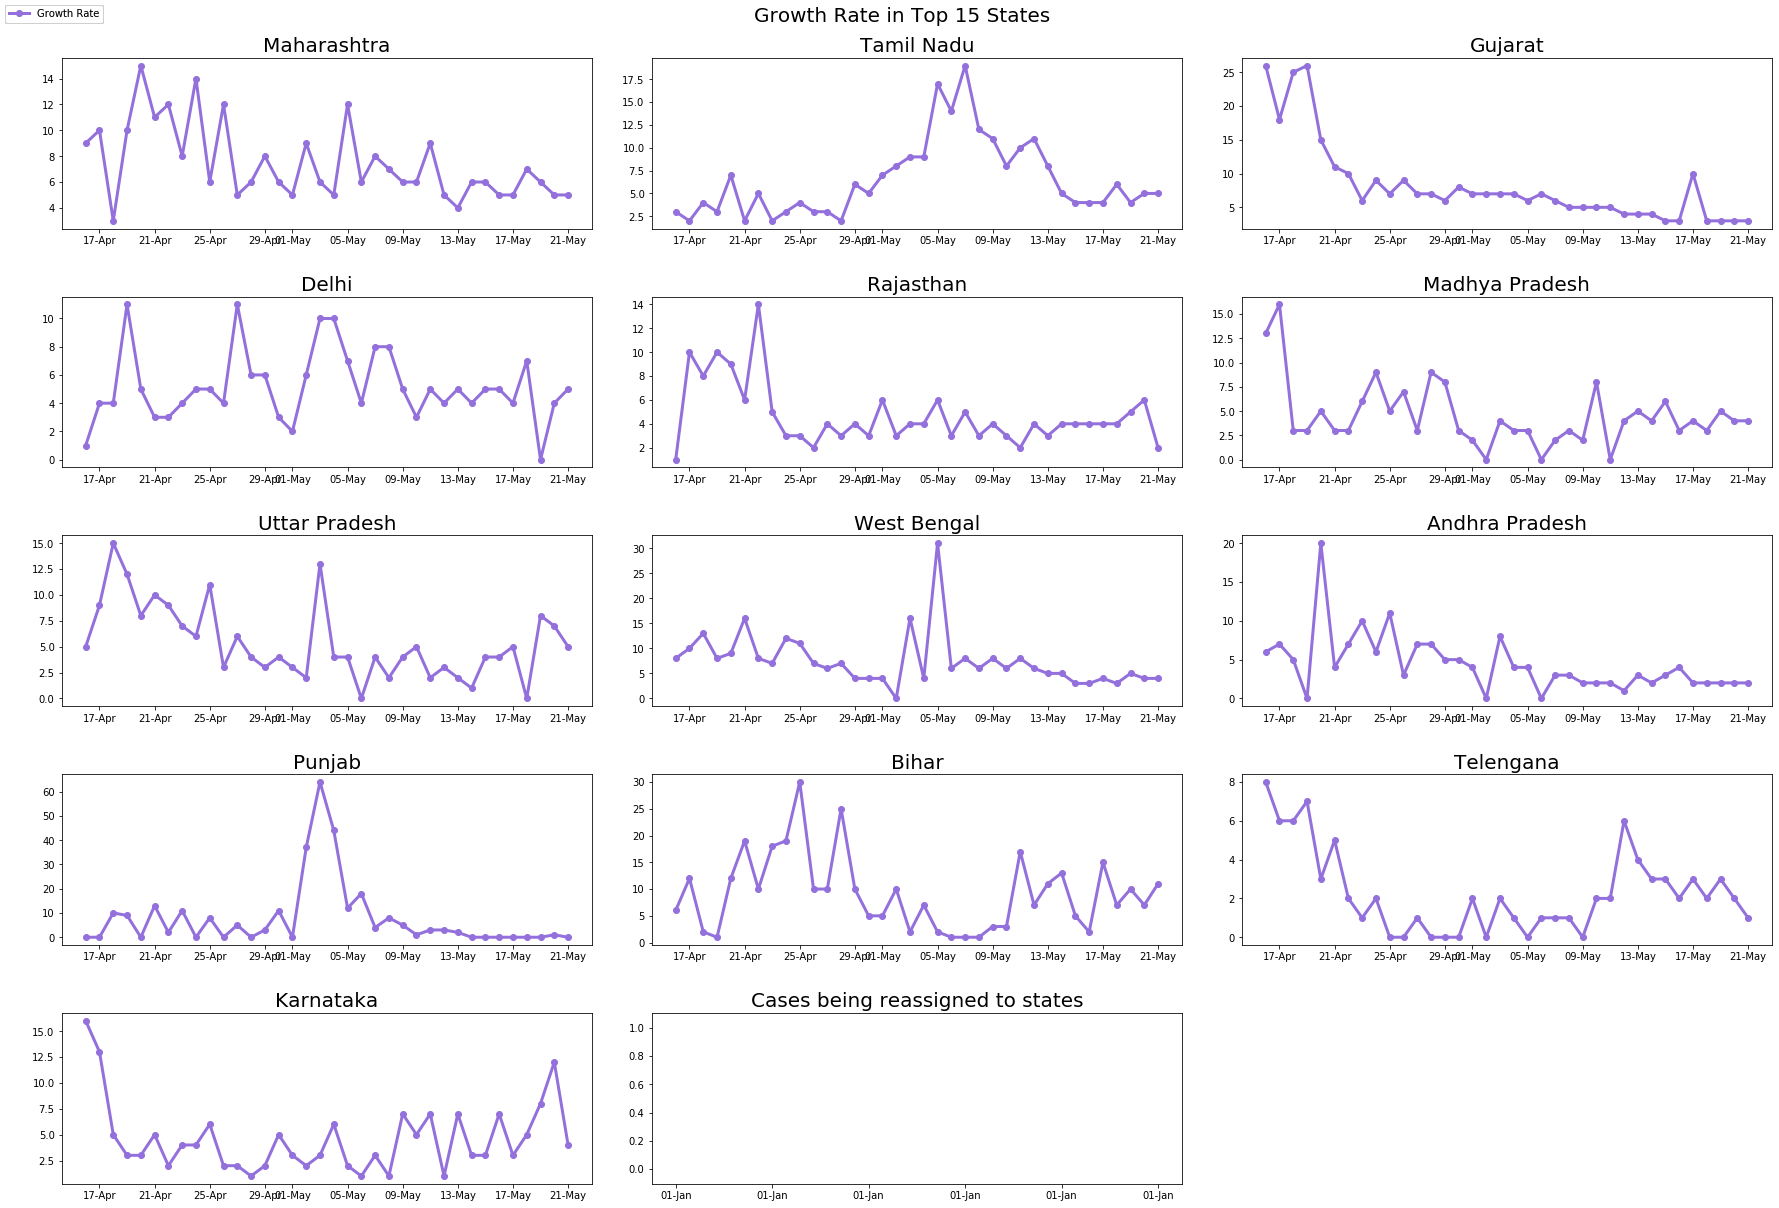

In [354]:
def calc_growthRate(values):
    k = []
    for i in range(1,len(values)):
        summ = 0
        for j in range(i):
            summ = summ + values[j]
        rate = (values[i]/summ)*100
        k.append(int(rate))
    return k

fig = plt.figure(figsize= (25,17))
plt.suptitle('Growth Rate in Top 15 States',fontsize = 20,y=1.0)
k=0
for i in range(1,15):
    ax = fig.add_subplot(5,3,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    #ax.bar(states_dates[states[k]],states_confirmed[states[k]],label = 'Day wise Confirmed Cases ') 
    growth_rate = calc_growthRate(states_confirmed[states[k]])
    ax.plot_date(states_dates[states[k]][21:],growth_rate[20:],color = '#9370db',label = 'Growth Rate',linewidth =3,linestyle='-')  
    plt.title(states[k],fontsize = 20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1
plt.tight_layout(pad=3.0)

In [355]:
# Exploring different types of hospital beds available in India during lockdown

In [356]:
cols_object = list(hospital_beds.columns[2:8])

for cols in cols_object:
    hospital_beds[cols] = hospital_beds[cols].astype(int,errors = 'ignore')

hospital_beds = hospital_beds.drop('Sno',axis=1)

In [357]:
hospital_beds.head(36)

,State/UT,NumPrimaryHealthCenters_HMIS,NumCommunityHealthCenters_HMIS,NumSubDistrictHospitals_HMIS,NumDistrictHospitals_HMIS,TotalPublicHealthFacilities_HMIS,NumPublicBeds_HMIS,NumRuralHospitals_NHP18,NumRuralBeds_NHP18,NumUrbanHospitals_NHP18,NumUrbanBeds_NHP18
0,Andaman & Nicobar Islands,27,4,NaN,3,34,1246,27,575,3,500
1,Andhra Pradesh,1417,198,31.0,20,1666,60799,193,6480,65,16658
2,Arunachal Pradesh,122,62,NaN,15,199,2320,208,2136,10,268
3,Assam,1007,166,14.0,33,1220,19115,1176,10944,50,6198
4,Bihar,2007,63,33.0,43,2146,17796,930,6083,103,5936
5,Chandigarh,40,2,1.0,4,47,3756,0,0,4,778
6,Chhattisgarh,813,166,12.0,32,1023,14354,169,5070,45,4342
7,Dadra & Nagar Haveli,9,2,1.0,1,13,568,10,273,1,316
8,Daman & Diu,4,2,NaN,2,8,298,5,240,0,0
9,Delhi,534,25,9.0,47,615,20572,0,0,109,24383


In [358]:
# Exploring top 10 States in each health facilities

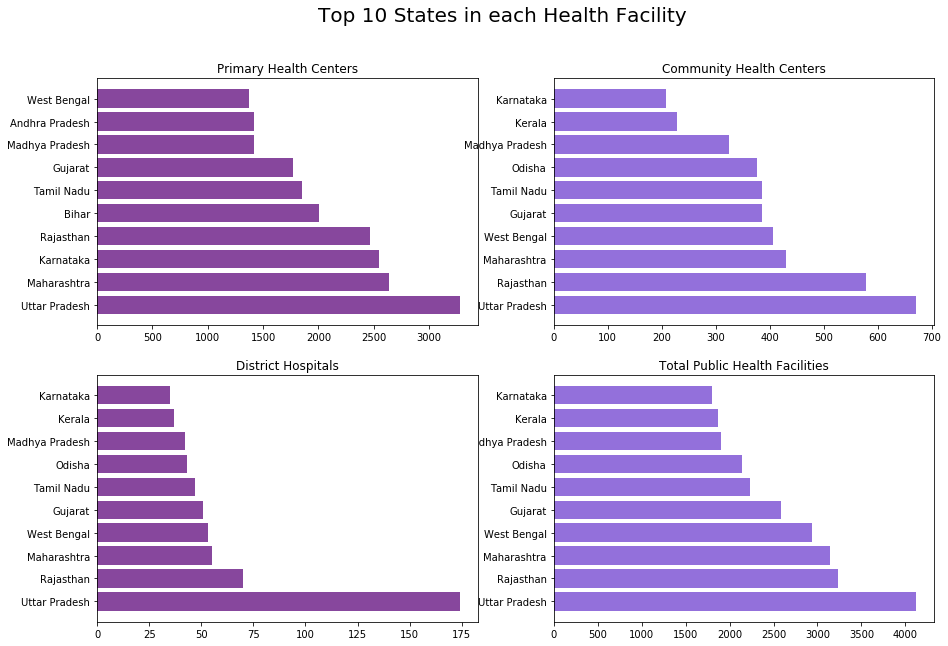

In [359]:
top_10_primary = hospital_beds.nlargest(10,'NumPrimaryHealthCenters_HMIS')
top_10_community = hospital_beds.nlargest(10,'NumCommunityHealthCenters_HMIS')
top_10_district_hospitals = hospital_beds.nlargest(10,'NumDistrictHospitals_HMIS')
top_10_public_facility = hospital_beds.nlargest(10,'TotalPublicHealthFacilities_HMIS')
top_10_public_beds = hospital_beds.nlargest(10,'NumPublicBeds_HMIS')

plt.figure(figsize=(15,10))
plt.suptitle('Top 10 States in each Health Facility',fontsize=20)
plt.subplot(221)
plt.title('Primary Health Centers')
plt.barh(top_10_primary['State/UT'],top_10_primary['NumPrimaryHealthCenters_HMIS'],color ='#87479d');

plt.subplot(222)
plt.title('Community Health Centers')
plt.barh(top_10_community['State/UT'],top_10_community['NumCommunityHealthCenters_HMIS'],color = '#9370db');

plt.subplot(224)
plt.title('Total Public Health Facilities')
plt.barh(top_10_community['State/UT'],top_10_public_facility['TotalPublicHealthFacilities_HMIS'],color='#9370db');

plt.subplot(223)
plt.title('District Hospitals')
plt.barh(top_10_community['State/UT'],top_10_district_hospitals['NumDistrictHospitals_HMIS'],color = '#87479d');

In [360]:
# Exploring Urban and Rural Healthcare Facility

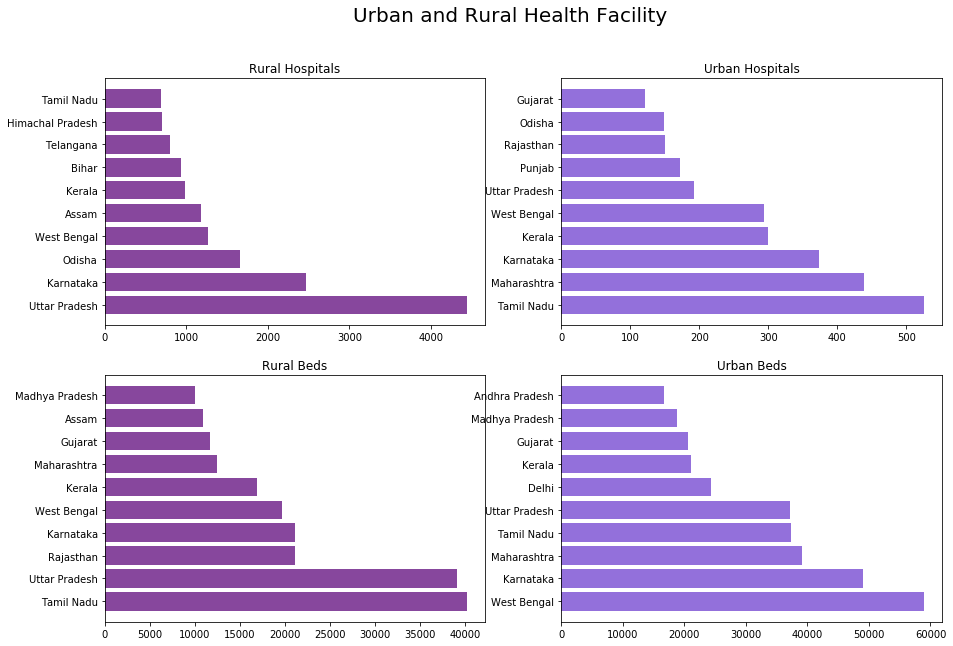

In [361]:
top_rural_hos = hospital_beds.nlargest(10,'NumRuralHospitals_NHP18')
top_rural_beds = hospital_beds.nlargest(10,'NumRuralBeds_NHP18')
top_urban_hos = hospital_beds.nlargest(10,'NumUrbanHospitals_NHP18')
top_urban_beds = hospital_beds.nlargest(10,'NumUrbanBeds_NHP18')

plt.figure(figsize=(15,10))
plt.suptitle('Urban and Rural Health Facility',fontsize=20)
plt.subplot(221)
plt.title('Rural Hospitals')
plt.barh(top_rural_hos['State/UT'],top_rural_hos['NumRuralHospitals_NHP18'],color = '#87479d');

plt.subplot(222)
plt.title('Urban Hospitals')
plt.barh(top_urban_hos['State/UT'],top_urban_hos['NumUrbanHospitals_NHP18'],color = '#9370db');

plt.subplot(223)
plt.title('Rural Beds')
plt.barh(top_rural_beds['State/UT'],top_rural_beds['NumRuralBeds_NHP18'],color = '#87479d');

plt.subplot(224)
plt.title('Urban Beds')
plt.barh(top_urban_beds['State/UT'],top_urban_beds['NumUrbanBeds_NHP18'],color = '#9370db');

In [362]:
# Exploring Statewise Testing Insights

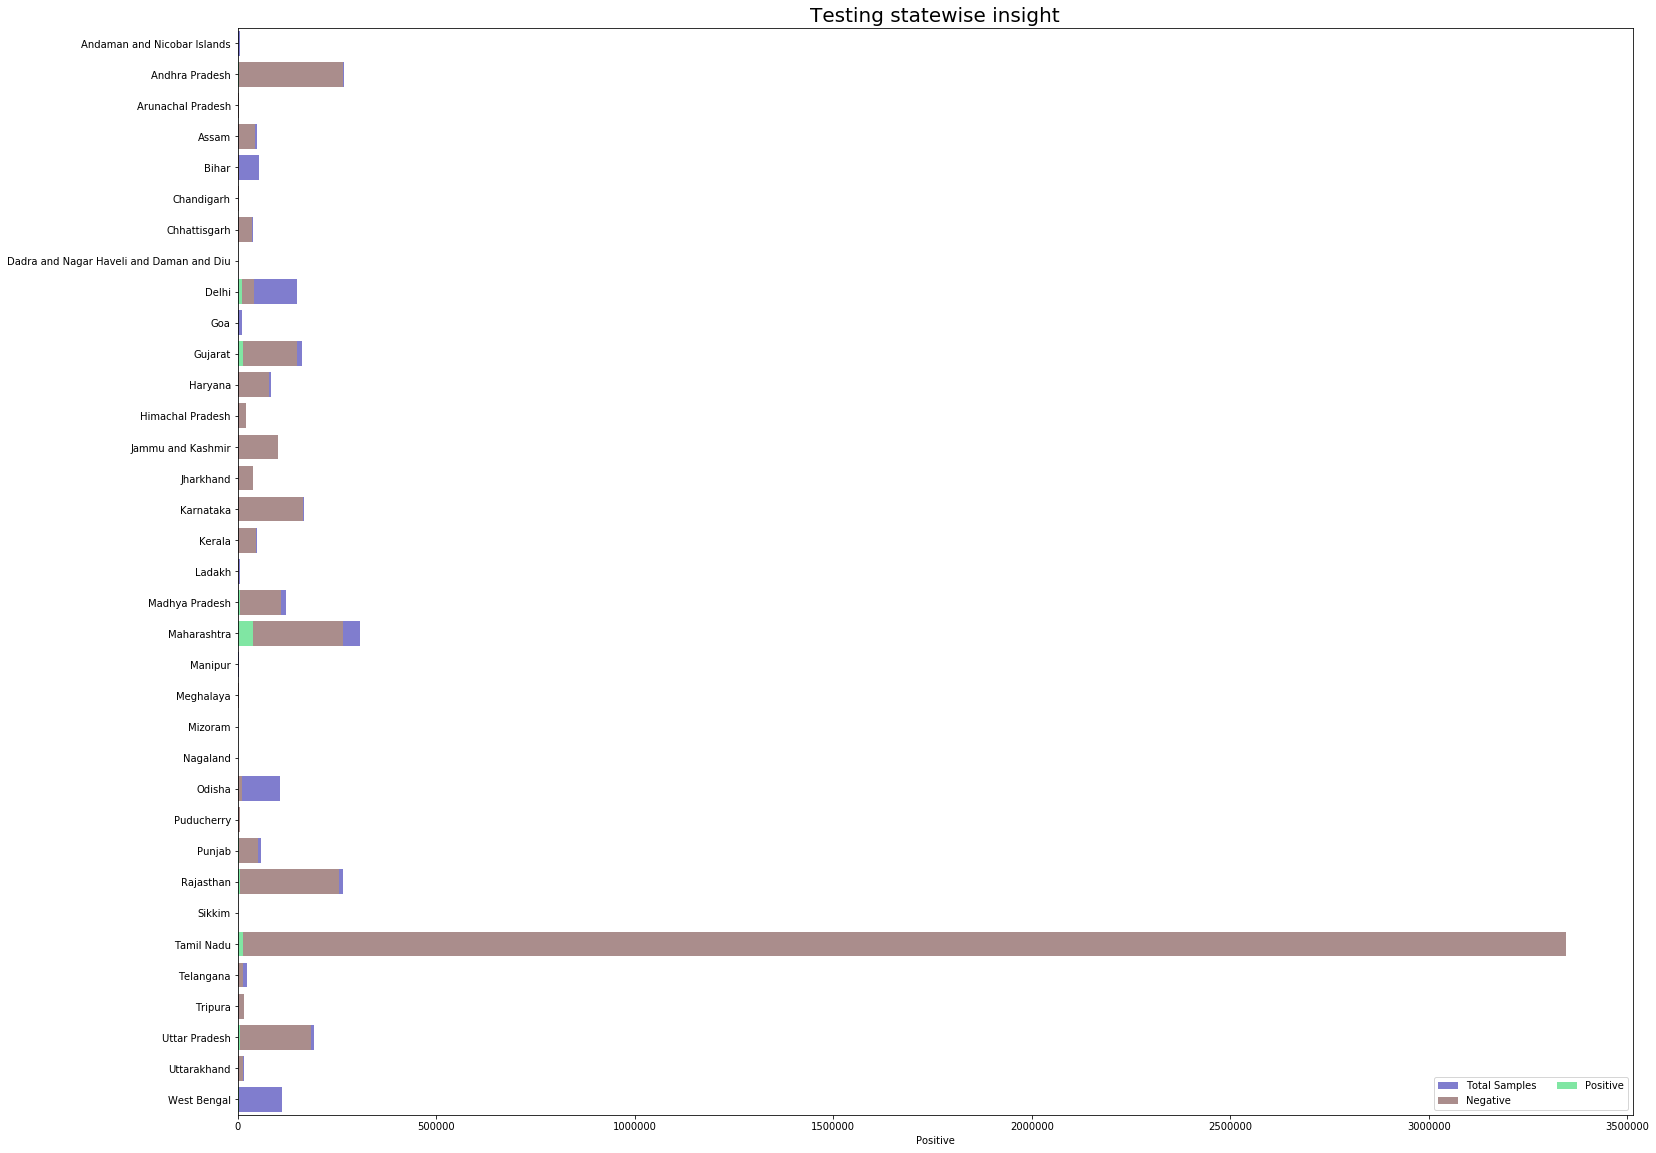

In [363]:
state_test = pd.pivot_table(state_testing, values=['TotalSamples','Negative','Positive'], index='State', aggfunc='max')
state_names = list(state_test.index)
state_test['State'] = state_names

plt.figure(figsize=(25,20))
sns.set_color_codes("pastel")
sns.barplot(x="TotalSamples", y= state_names, data=state_test,label="Total Samples", color = '#7370db')
sns.barplot(x='Negative', y=state_names, data=state_test,label='Negative', color= '#af8887')
sns.barplot(x='Positive', y=state_names, data=state_test,label='Positive', color='#6ff79d')
plt.title('Testing statewise insight',fontsize = 20)
plt.legend(ncol=2, loc="lower right", frameon=True);

In [364]:
# Number of ICMR Testing Centres in each state

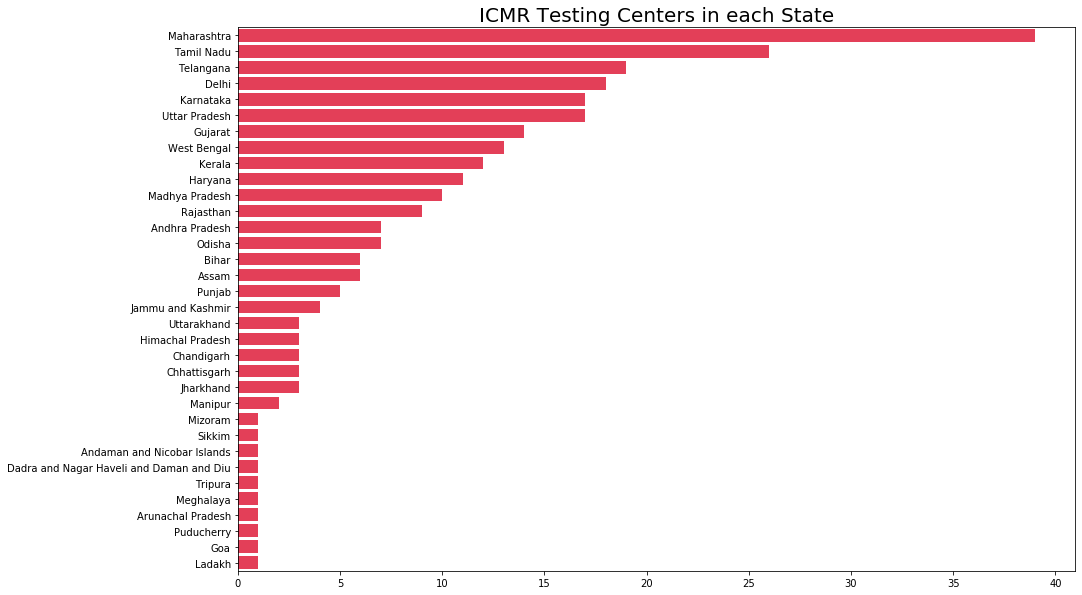

In [365]:
values = list(ICMR_labs['state'].value_counts())
names = list(ICMR_labs['state'].value_counts().index)

plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
plt.title('ICMR Testing Centers in each State', fontsize = 20)
sns.barplot(x= values, y= names,color = '#ff2345');

In [366]:
# Let's Start with the predictions

In [367]:
train = pd.read_csv(r'C:\Users\Srishiti\Desktop\projects\covid analysis\train.csv')
test = pd.read_csv(r'C:\Users\Srishiti\Desktop\projects\covid analysis\test.csv')
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [368]:
!pip install Prophet

In [370]:
# ARIMA Model

In [371]:
k = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':]
india_confirmed = k.values.tolist()[0] 
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = india_confirmed

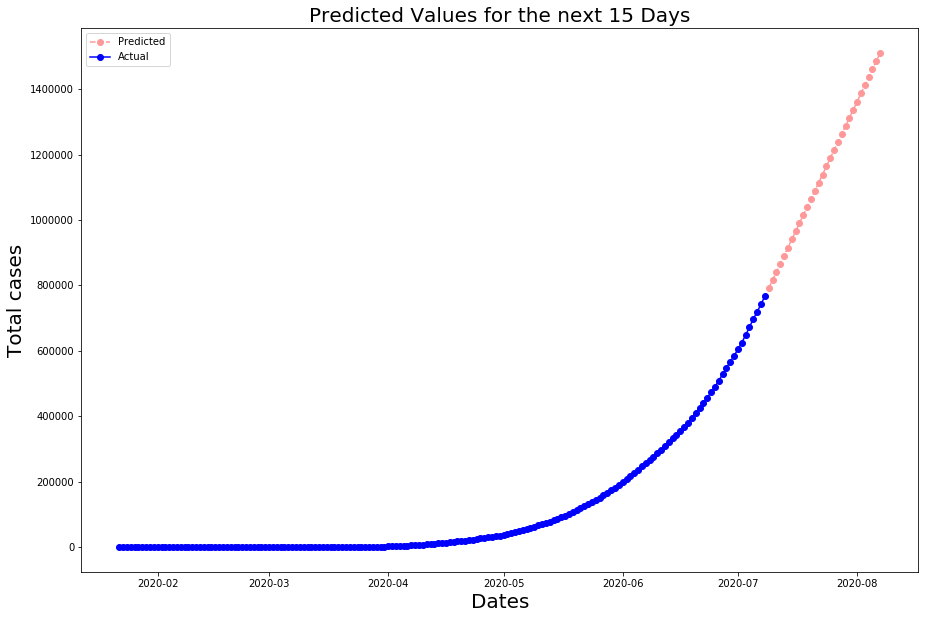

In [372]:
from statsmodels.tsa.arima_model import ARIMA

from datetime import timedelta 

arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])

start_date = data['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)

plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();

In [373]:
# 1.4 Visualising the spread geographically

In [374]:
# Learn how to use folium to create a zoomable map
map = folium.Map(location=[20, 70], zoom_start=4,tiles='Stamenterrain')

for lat, lon, value, name in zip(df_india['Latitude'], df_india['Longitude'], df_india['Total Confirmed cases*'], df_india['State/UnionTerritory']):
    folium.CircleMarker([lat, lon], radius=value*0.0002, popup = ('<strong>State</strong>: ' + str(name).capitalize() + '<br>''<strong>Total Cases</strong>: ' + str(value) + '<br>'),color='red',fill_color='red',fill_opacity=0.3 ).add_to(map)
map

In [375]:
# Part 3: Exploring World wide data

In [376]:
# 3.1 Visualizing: Worldwide NCOVID-19 cases

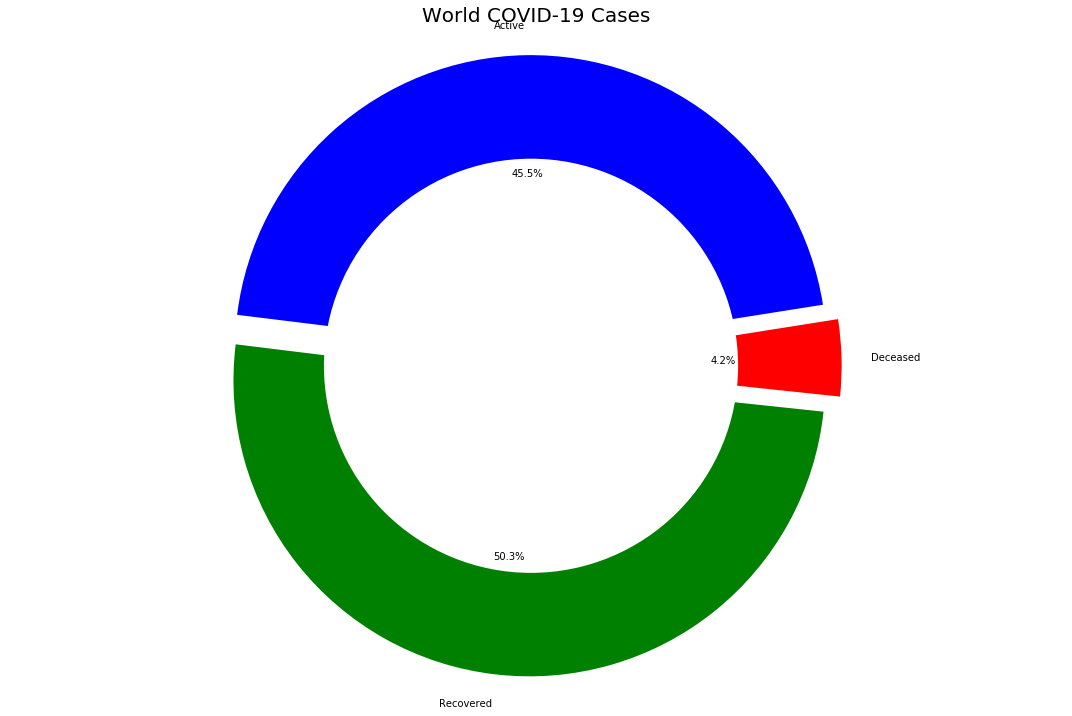

In [377]:
world_confirmed = confirmed_df[confirmed_df.columns[-1:]].sum()
world_recovered = recovered_df[recovered_df.columns[-1:]].sum()
world_deaths = deaths_df[deaths_df.columns[-1:]].sum()
world_active = world_confirmed - (world_recovered - world_deaths)

labels = ['Active','Recovered','Deceased']
sizes = [world_active,world_recovered,world_deaths]
color= ['blue','green','red']
explode = []

for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode = explode,colors = color)
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('World COVID-19 Cases',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

In [378]:
dates

[Timestamp('2020-01-22 00:00:00'),
 Timestamp('2020-01-23 00:00:00'),
 Timestamp('2020-01-24 00:00:00'),
 Timestamp('2020-01-25 00:00:00'),
 Timestamp('2020-01-26 00:00:00'),
 Timestamp('2020-01-27 00:00:00'),
 Timestamp('2020-01-28 00:00:00'),
 Timestamp('2020-01-29 00:00:00'),
 Timestamp('2020-01-30 00:00:00'),
 Timestamp('2020-01-31 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-02-02 00:00:00'),
 Timestamp('2020-02-03 00:00:00'),
 Timestamp('2020-02-04 00:00:00'),
 Timestamp('2020-02-05 00:00:00'),
 Timestamp('2020-02-06 00:00:00'),
 Timestamp('2020-02-07 00:00:00'),
 Timestamp('2020-02-08 00:00:00'),
 Timestamp('2020-02-09 00:00:00'),
 Timestamp('2020-02-10 00:00:00'),
 Timestamp('2020-02-11 00:00:00'),
 Timestamp('2020-02-12 00:00:00'),
 Timestamp('2020-02-13 00:00:00'),
 Timestamp('2020-02-14 00:00:00'),
 Timestamp('2020-02-15 00:00:00'),
 Timestamp('2020-02-16 00:00:00'),
 Timestamp('2020-02-17 00:00:00'),
 Timestamp('2020-02-18 00:00:00'),
 Timestamp('2020-02-

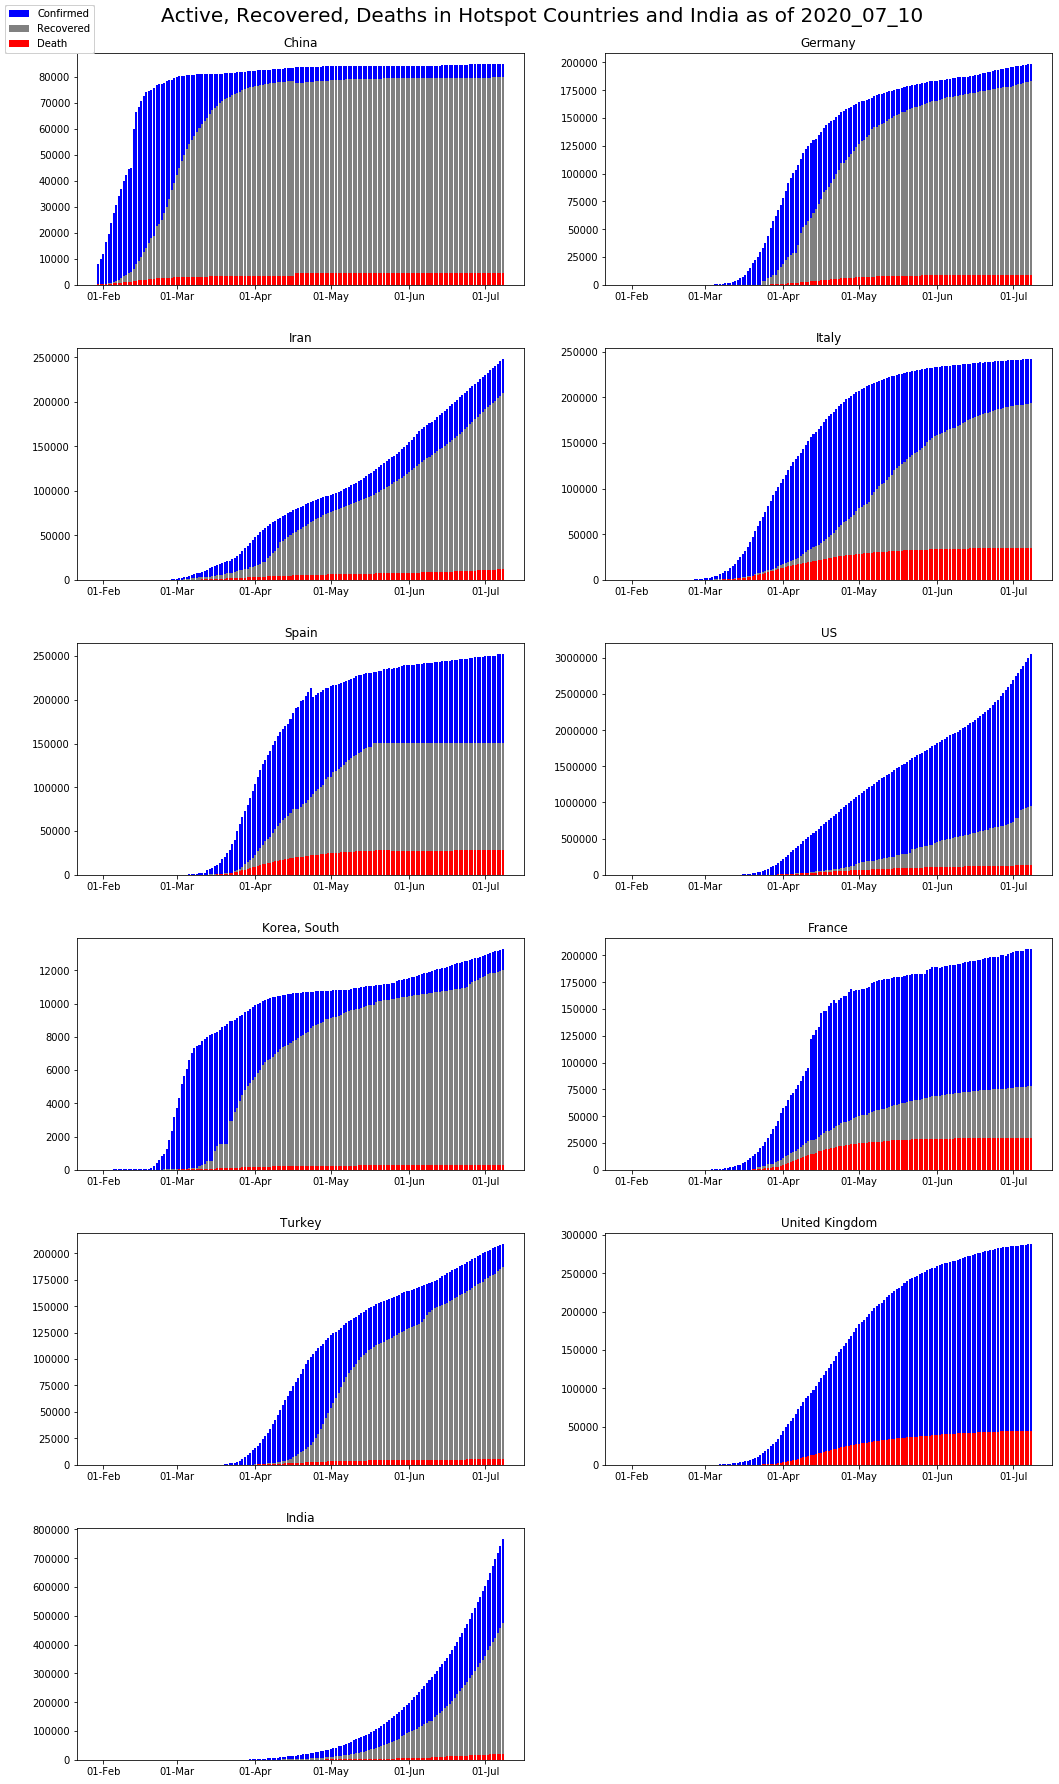

In [379]:
hotspots = ['China','Germany','Iran','Italy','Spain','US','Korea, South','France','Turkey','United Kingdom','India']
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]

df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()

global_confirmed = {}
global_deaths = {}
global_recovered = {}
global_active= {}

for country in hotspots:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed[country] = k.values.tolist()[0]

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths[country] = k.values.tolist()[0]

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_recovered[country] = k.values.tolist()[0]
    
# for country in hotspots:
#     k = list(map(int.__sub__, global_confirmed[country], global_deaths[country]))
#     global_active[country] = list(map(int.__sub__, k, global_recovered[country]))
    
fig = plt.figure(figsize= (15,25))
plt.suptitle('Active, Recovered, Deaths in Hotspot Countries and India as of '+ today,fontsize = 20,y=1.0)
#plt.legend()
k=0
for i in range(1,12):
    ax = fig.add_subplot(6,2,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    # ax.bar(dates_india,global_active[hotspots[k]],color = 'green',alpha = 0.6,label = 'Active');
    ax.bar(dates_india,global_confirmed[hotspots[k]],color='blue',label = 'Confirmed');
    ax.bar(dates_india,global_recovered[hotspots[k]],color='grey',label = 'Recovered');
    ax.bar(dates_india,global_deaths[hotspots[k]],color='red',label = 'Death');   
    plt.title(hotspots[k])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1

plt.tight_layout(pad=3.0)

In [380]:
countries = ['China','Germany','Iran','Italy','Spain','US','Korea, South','France','United Kingdom','India']

global_confirmed = []
global_recovered = []
global_deaths = []

for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0]) 

    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0]) 

    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0])  

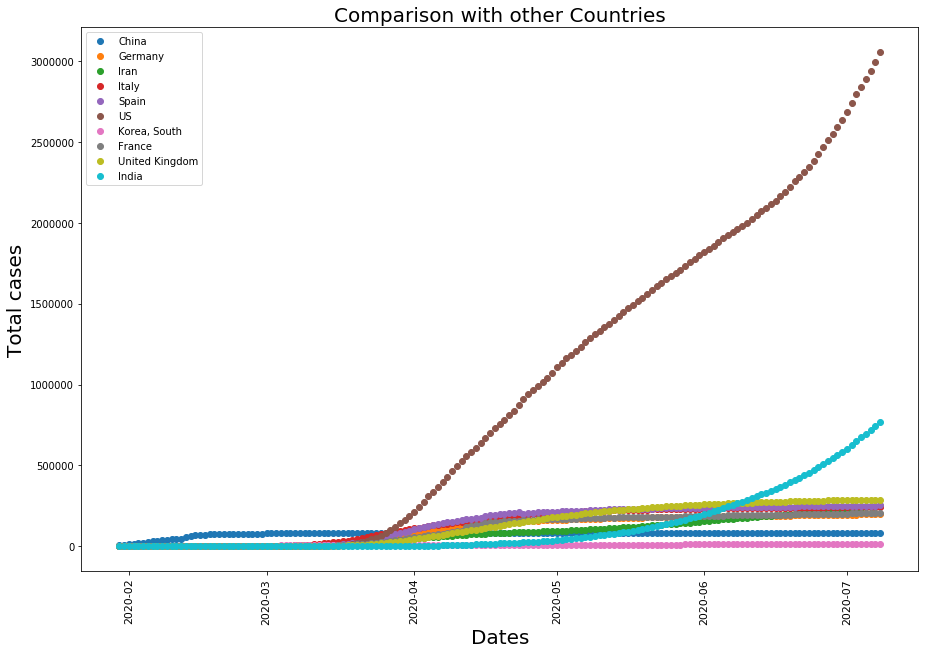

In [381]:
plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Comparison with other Countries" , fontsize = 20)

for i in range(len(countries)):
    plt.plot_date(y= global_confirmed[i],x= dates_india,label = countries[i])
plt.legend();